## Basic Optimization using BAX
In this notebook we demonstrate the use of Xopt to perform Bayesian Algorithm Execution (BAX) as a means of minimizing the output of a simple test function. BAX is a generalization of Bayesian Optimization that seeks to acquire observations that provide our model with maximal information about our property of interest. In this simple example, our property of interest is the minimum function output and its location in input-space. See https://arxiv.org/pdf/2209.04587.pdf for details.

# Imports and random seeding for reproducibility

In [1]:
# Ignore all warnings
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os    
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import torch

from xopt import Xopt
from xopt.vocs import VOCS
from xopt.generators.bayesian.bax_generator import (BaxGenerator, 
                                                    BaxOptions, 
                                                    BayesianAlgorithmExecutionOptions, 
                                                    GridMinimizeExecutorOptions
                                                   )
# from xopt.generators.bayesian.bax.algorithms import GridMinimize
from xopt.evaluator import Evaluator

import time
import numpy as np
import random


#random seeds for reproducibility 
rand_seed = 2

torch.manual_seed(rand_seed)
np.random.seed(rand_seed) #only affects initial random observations through Xopt
random.seed(rand_seed)

## Define the test problem
Here we define a simple optimization problem, where we attempt to minimize the sin
function in the domian [0,2*pi]. Note that the function used to evaluate the
objective function takes a dictionary as input and returns a dictionary as the output.

In [2]:
import math

# define variables and function objectives
vocs = VOCS(
    variables={"x": [0, 2 * math.pi]},
    objectives={"f": "MINIMIZE"},
)

In [3]:
# define a test function to optimize
import numpy as np

def sin_function(input_dict):
    return {"f": np.sin(input_dict["x"])}

## Prepare BAX generator for Xopt
Create a generator that uses the ExpectedInformationGain (InfoBAX) acquisition function to perform Bayesian Optimization.

In [4]:
# #Prepare BAX algorithm and generator options
algo_options = GridMinimizeExecutorOptions(n_samples=10, n_steps_sample_grid=21)
acq_options = BayesianAlgorithmExecutionOptions(algo=algo_options)
generator_options = BaxOptions(acq=acq_options)

#construct BAX generator
generator = BaxGenerator(vocs, generator_options)

## Create Evaluator and Xopt objects
Create the Evaluator (which allows Xopt to interface with our test function) and finish constructing our Xopt object.

In [5]:
#construct evaluator
evaluator = Evaluator(function=sin_function)

#construct Xopt optimizer
X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)

## Generate and evaluate initial points
To begin optimization, we must generate some random initial data points. The first call
to `X.step()` will generate and evaluate a number of randomly points specified by the
 generator. Note that if we add data to xopt before calling `X.step()` by assigning
 the data to `X.data`, calls to `X.step()` will ignore the random generation and
 proceed to generating points via Bayesian optimization.

In [6]:
# print initial number of points to be generated
print(X.generator.options.n_initial)

# call X.step() to generate + evaluate initial points
X.step()

# inspect the gathered data
X.data

3


,x,f,xopt_runtime,xopt_error
1,3.543749,-0.391403,0.000009,False
2,6.120286,-0.162180,0.000002,False
3,2.829554,0.306999,0.000001,False


## Do bayesian optimization steps
To perform optimization we simply call `X.step()` in a loop. This allows us to do
intermediate tasks in between optimization steps, such as examining the model and
acquisition function at each step (as we demonstrate here).

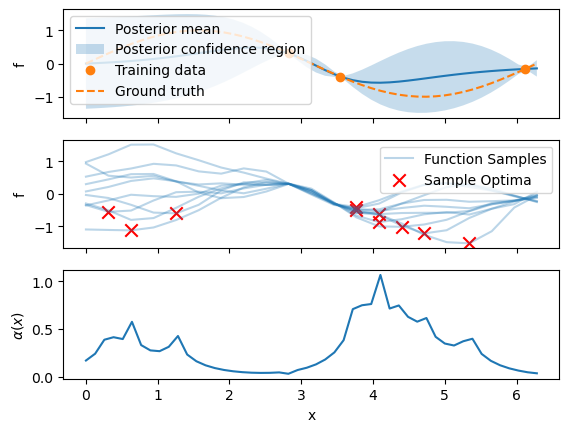

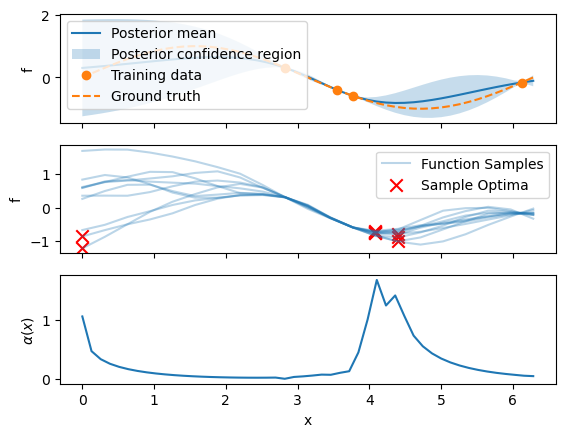

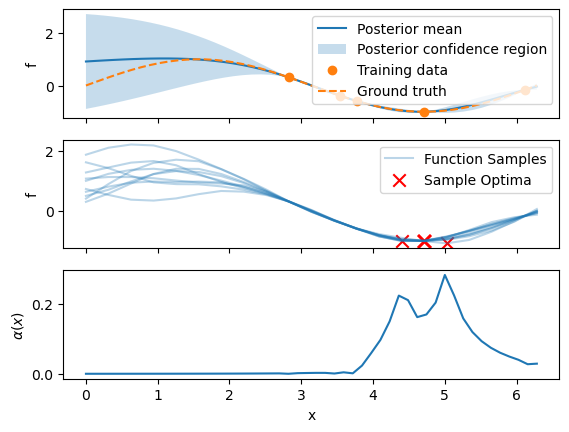

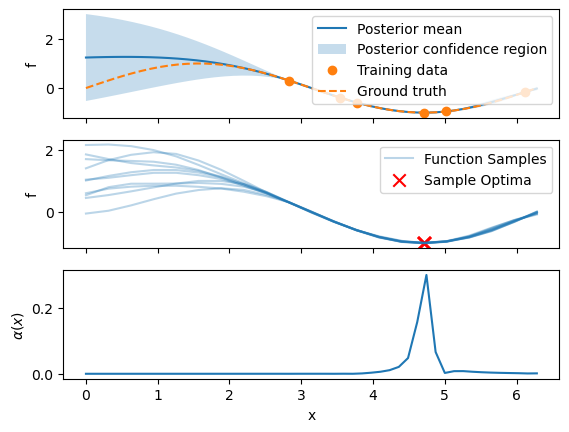

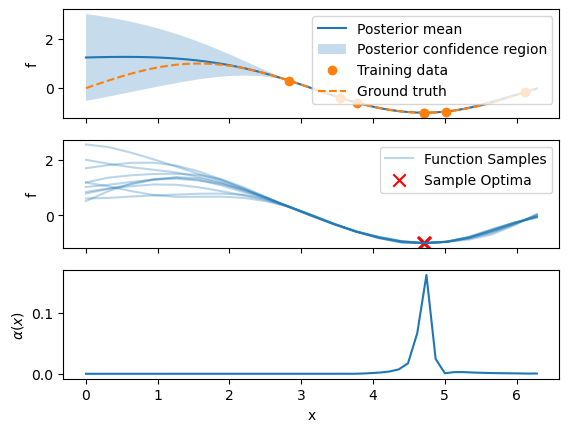

In [7]:
import torch
import matplotlib.pyplot as plt
n_steps = 3

# test points for plotting
test_x = torch.linspace(*X.vocs.bounds.flatten(),50).double()

for i in range(5):
    # get the Gaussian process model from the generator
    model = X.generator.train_model()

    # get acquisition function from generator
    acq = X.generator.get_acquisition(model)

    # calculate model posterior and acquisition function at each test point
    # NOTE: need to add a dimension to the input tensor for evaluating the
    # posterior and another for the acquisition function, see
    # https://botorch.org/docs/batching for details
    # NOTE: we use the `torch.no_grad()` environment to speed up computation by
    # skipping calculations for backpropagation
    with torch.no_grad():
        posterior = model.posterior(test_x.unsqueeze(1))
        acq_val = acq(test_x.reshape(-1,1,1))

    # get mean function and confidence regions
    mean = posterior.mean
    l,u = posterior.mvn.confidence_region()

    # plot model and acquisition function
    fig,ax = plt.subplots(3,1,sharex="all")

    # plot model posterior
    ax[0].plot(test_x, mean, label="Posterior mean")
    ax[0].fill_between(test_x, l, u,alpha=0.25, label="Posterior confidence region")

    # add data to model plot
    ax[0].plot(X.data["x"],X.data["f"],"C1o", label="Training data")

    # plot true function
    true_f = sin_function({"x": test_x})["f"]
    ax[0].plot(test_x, true_f,'--', label="Ground truth")

    # add legend
    ax[0].legend()

    # plot the function samples and their optima found by BAX
    xs_exe = X.generator.algo_results['xs_exe']
    ys_exe = X.generator.algo_results['ys_exe']
    sample_xs = X.generator.algo_results['sample_xs']
    sample_ys = X.generator.algo_results['sample_ys']
    label1 = 'Function Samples'
    label2 = 'Sample Optima'
    for i in range(X.generator.algo_executor.n_samples):
        samples, = ax[1].plot(sample_xs.flatten(), sample_ys[i].flatten(), c='C0', alpha=0.3, label=label1)
        optima = ax[1].scatter(xs_exe.flatten()[i], ys_exe.flatten()[i], c='r', marker='x', s=80, label=label2)
        label1 = None
        label2 = None 
    
    # add legend
    ax[1].legend()
    
    # plot acquisition function
    ax[2].plot(test_x, acq_val.flatten())

    ax[0].set_ylabel("f")
    ax[1].set_ylabel("f")
    ax[2].set_ylabel(r"$\alpha(x)$")
    ax[2].set_xlabel("x")

    # do the optimization step
    X.step()


In [8]:
# access the collected data
X.data

,x,f,xopt_runtime,xopt_error
1,3.543749,-0.391403,0.000009,False
2,6.120286,-0.162180,0.000002,False
3,2.829554,0.306999,0.000001,False
4,3.770225,-0.588039,0.000010,False
5,4.712210,-1.000000,0.000008,False
6,5.023118,-0.952111,0.000009,False
7,4.712390,-1.000000,0.000006,False
8,4.712389,-1.000000,0.000006,False


## Getting the optimization result
To get the ideal point (without evaluating the point) we ask the generator to
generate a new point.

In [9]:
X.generator.get_optimum()

,x
0,4.718982


## Customizing optimization
Each generator has a set of options that can be modified to effect optimization behavior

In [10]:
X.generator.options.dict()

{'optim': {'num_restarts': 20,
  'raw_samples': 20,
  'sequential': True,
  'max_travel_distances': None,
  'use_turbo': False},
 'acq': {'proximal_lengthscales': None,
  'use_transformed_proximal_weights': True,
  'monte_carlo_samples': 128,
  'algo': {'AlgoClass': xopt.generators.bayesian.bax.algorithms.GridMinimizeExecutor,
   'n_samples': 10,
   'n_steps_sample_grid': 21}},
 'model': {'name': 'standard',
  'custom_constructor': None,
  'use_low_noise_prior': True,
  'covar_modules': {},
  'mean_modules': {}},
 'n_initial': 3,
 'use_cuda': False}

In [11]:
# example: add a Gamma(1.0,10.0) prior to the noise hyperparameter to reduce model noise
# (good for optimizing noise-free simulations)
X.generator.options.model.use_low_noise_prior = True

In [12]:
X.generator.options.acq.algo.dict()

{'AlgoClass': xopt.generators.bayesian.bax.algorithms.GridMinimizeExecutor,
 'n_samples': 10,
 'n_steps_sample_grid': 21}